In [1]:
from torchfunction.device import AutoDevice as device
from torchfunction.utils import tonumpy as tn
import torch
from matplotlib import pyplot as plt
import tqdm
from tqdm import trange, tqdm
import matplotlib as mpl
import torch.nn as nn
import math
import scipy
import numpy as np
import scipy.stats as stats
from dataset import get_standard_spike_input

from zytlib import path, table

import matplotlib as mpl
dcolor = mpl.rcParams["axes.prop_cycle"].by_key()['color']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

torch.set_printoptions(precision=2, sci_mode=False, linewidth=140, profile="short")
%config InlineBackend.figure_format = "retina"

mod_color = ['#5B6564', '#4A65B5']

[0.05052857142857143, 0.05592571428571429, 0.0716, 0.06735714285714285, 0.06764857142857143, 0.05570571428571429, 0.07767714285714286, 0.05476]
Using GPU device 2...


In [2]:
from model import lowrank_encoder, reparameter_encoder
from dataset import get_spike_input


In [3]:
def save_figure(name, path=None, dpi=300, format="jpg"):
    if isinstance(format, (list, tuple)):
        for f in format:
            save_figure(name, path=path, dpi=dpi, format=f)
        return
    if path is None:
        plt.savefig(figure_path / "{}.{}".format(name, format), format=format, dpi=dpi)
    else:
        p = (figure_path / path).mkdir()
        plt.savefig(p / "{}.{}".format(name, format), format=format, dpi=dpi)
figure_path = path("figure/figure5/").mkdir()


In [4]:
rnn_hyper = table(tau=100, delta_t=20, encoder_dim=5000, noise_rec=0.00, noise_inp=0.0, input_dim=4,
                  input_gain = 1.0, output_dim = 1, max_rank = 3, init_gain = 0.01, n_populations = 3, weights_lr = 0,
                  fixed_I = False, fixed_W = False, readout_radius = 4, zero_mean = True, zero_variance = False,
                  fixed_population = "", fixed_rank = "", phi = "torch.tanh", symmetric_expanded = None,
                  has_bias = False, device = device)

In [5]:
class modified_encoder(reparameter_encoder):
    def C(self):
        C = self._C.clone()
        C[2, 9, 3] = C[1, 9, 2]
        C[2, 9, 4] = C[1, 9, 4]
        return C

In [6]:
@torch.no_grad()
def get_gain_from_rnn(rnn):
    rnn.pre_forward()
    gain = (1 - rnn.phi(rnn._I + torch.randn_like(rnn._I) * rnn.hyper.noise_rec)[:, :, 2:].pow(2)).mean(1).T.detach()
    return gain

def np_str(v, p=3):
    if isinstance(v, float):
        return eval("f'{v:." + str(p) + "g}'")
    return [eval("f'{x:." + str(p) + "g}'") for x in tn(v)]

In [7]:
def print_dict_shapes(data, indent=''):
    for key, value in data.items():
        if isinstance(value, dict):
            print(f"{indent}{key}:")
            print_dict_shapes(value, indent + '\t')
        elif isinstance(value, list):
            print(f"{indent}{key}: list of length {len(value)}")
            if value:
                print(f"{indent}\tFirst element:")
                # 创建一个临时字典来递归处理第一个元素
                temp_data = {'First element': value[0]}
                print_dict_shapes(temp_data, indent + '\t')
        else:
            print(f"{indent}{key}: {getattr(value, 'shape', 'Not an array or tensor')}")
            
def cosine_similarity(vector_a, vector_b):
    # Compute the dot product
    dot_product = torch.dot(vector_a, vector_b)

    # Compute the magnitudes (L2 norms)
    magnitude_a = torch.norm(vector_a)
    magnitude_b = torch.norm(vector_b)

    # Handle the corner case where the magnitude of either vector is zero
    if magnitude_a == 0 or magnitude_b == 0:
        raise ValueError("One or both of the vectors have zero magnitude, cannot compute cosine similarity.")

    # Compute the cosine of the angle between the vectors
    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    return cosine_angle.item()

In [8]:
def power_method_batch_lowrank(U, V, num_iterations=1000, tolerance=1e-6):
    if U.dim() == 3:
        batch_size, n, _ = U.shape
        V_T = V.permute([0, 2, 1])
        # Initialize a random vector for each batch
        b_k = torch.rand((batch_size, n), dtype=U.dtype, device=U.device)
        b_k = b_k / torch.norm(b_k, dim=1, keepdim=True)  # Normalize

        for _ in range(num_iterations):
            # Compute A * b_k for each batch
            b_k1 = torch.bmm(U, torch.bmm(V_T / n, b_k.unsqueeze(-1))).squeeze(-1)
            # Normalize
            b_k1_norm = torch.norm(b_k1, dim=1, keepdim=True)
            b_k1 = b_k1 / b_k1_norm
            # Check for convergence
            if torch.norm(b_k1 - b_k) < tolerance:
                break
            b_k = b_k1

        # Compute the corresponding eigenvalues
        eigenvalues = torch.bmm(b_k.unsqueeze(1), torch.bmm(U, torch.bmm(V_T, b_k.unsqueeze(-1)))).squeeze(-1).squeeze(-1) / n
        # Ensure the eigenvector is normalized
        eigenvalues = eigenvalues / torch.sum(b_k**2, dim=1)
        return eigenvalues, b_k
    else:
        U = U.unsqueeze(0)
        V = V.unsqueeze(0)
        e, b = power_method_batch_lowrank(U, V, num_iterations=num_iterations, tolerance=tolerance)
        return e[0], b[0, :]

In [9]:
C = torch.zeros(3, 11, 7)
C[1, 2, 5] = 1
C[2, 3, 6] = 1

In [10]:
rnn = modified_encoder(R = 7, **rnn_hyper)
rnn._C.data.copy_(C)
print("successfully load the model")

successfully load the model


In [11]:
gain_matrix = get_gain_from_rnn(rnn)
g = gain_matrix[0, 1].item()
print(gain_matrix, g)


tensor([[1.00, 0.60, 1.00],
        [1.00, 1.00, 0.61]], device='cuda:2') 0.5966319441795349


In [12]:
def make_c(g, alpha, beta, gamma):
    C = torch.zeros(3, 11, 7)

    a, b = -g * 3 / (1 - g**2), 3 / (1 - g**2)
    c = 3
    d = gamma * 3

    I_shift = 0
    U_shift = 4
    V_shift = 7
    W_shift = 10

    C[1, 2, 5] = 1
    C[2, 3, 6] = 1

    C[0, I_shift, 0] = 1
    C[0, V_shift, 0] = d
    C[0, I_shift+1, 1] = 1
    C[0, V_shift+1, 1] = d

    C[1:3, I_shift, 0] = 1
    C[1, V_shift+2, 0] = a * alpha
    C[2, V_shift+2, 0] = b * alpha
    C[1:3, I_shift+1, 1] = 1
    C[1, V_shift+2, 1] = b * alpha
    C[2, V_shift+2, 1] = a * alpha

    # recurrence
    C[0, U_shift+2, 4] = 1
    C[0, V_shift+2, 4] = c

    # iv -> dv
    C[1:3, U_shift, 2] = 1
    C[1, V_shift+2, 2] = a * beta
    C[2, V_shift+2, 2] = b * beta

    C[1:3, U_shift+1, 3] = 1
    C[1, V_shift+2, 3] = b * beta
    C[2, V_shift+2, 3] = a * beta

    C[0, W_shift, 4] = 1
    return C

In [14]:
def get_results(alpha, beta, gamma, g):
    results = table()
    results.alpha = alpha
    results.gamma = gamma
    results.beta = beta
    results.inp_mod = alpha / (alpha + beta * gamma)
    results.sel_mod = beta * gamma / (alpha + beta * gamma)

    C = make_c(g, alpha, beta, gamma)
    rnn._C.data.copy_(C)
    rnn.resample(whiten=True)

    all_result = list()
    k = 10
    
    inp_mod_lda = torch.zeros(k, 2)
    sel_mod_lda = torch.zeros(k, 2)
    
    for j in range(k):
        result_dict = dict()
        with torch.no_grad():
            rnn.resample(whiten=True)
            sv = [None, None]
            I = [[None, None], [None, None]]
            choice = [None, None]
            gain = [None, None]
            rnn_U = rnn._U.reshape(-1, rnn.hyper.max_rank)
            rnn_V = rnn._V.reshape(-1, rnn.hyper.max_rank)
            rnn_I = rnn._I.reshape(-1, rnn.hyper.input_dim)
            spike_input, y, mask, cnds, ctx, cnd_ctx = get_spike_input(256, fixed_t=10)
            h = rnn(spike_input.to(device), noise_inp=0)
    #         print(h.shape)
            for c in [0, 1]:
                h1 = h[ctx == c, 10:20, :][:10].clone()
                x = h1.view(-1, h1.shape[-1]).detach().clone()
                with torch.enable_grad():
                    x.requires_grad_()
                    slow_point_optim = torch.optim.Adam([x], lr=1e-2)
                    ctx_vector = [[0.0, 0, 1, 0], [0.0, 0, 0, 1]][c]
                    for k in range(75):
                        slow_point_optim.zero_grad()
                        v = rnn.velocity(x, torch.tensor(ctx_vector).to(device).view(1, 4).repeat(x.shape[0], 1))
                        q = v.pow(2).sum(-1) * 0.5
                        loss = q.mean()
                        (loss).backward()
                        slow_point_optim.step()
    #                     tbar.set_postfix({"loss": np_str(loss.item()),
    #                                       })
                K = x[q < 1, :].shape[0]
                x1 = x[q < 1, :]
                gain1 = (1 - torch.tanh(x1).pow(2))
                rnn_GainedU = torch.einsum("bn,nr->bnr", gain1, rnn_U)
                rnn_GainedV = rnn_V.unsqueeze(0).repeat(gain1.shape[0], 1, 1)
                S = power_method_batch_lowrank(rnn_GainedU, rnn_GainedV)[0]
                i = (S-1).pow(2).min(dim=0).indices.item()
    #             print(S[i])

                x1 = x[q < 1, :][i]
                gain1 = (1 - torch.tanh(x1).pow(2))
                rnn_GainedU = torch.einsum("i,ir->ir", gain1, rnn_U)
                S, V = power_method_batch_lowrank(rnn_V, rnn_GainedU)
                sv[c] = V
                I[0][c] = gain1 * rnn_I[:, 0]
                I[1][c] = gain1 * rnn_I[:, 1]

                S, V = power_method_batch_lowrank(rnn_GainedU, rnn_V)
                choice[c] = V
                gain[c] = gain1
            if (sv[0] * I[0][0]).sum() < 0:
                sv[0] = -sv[0]
            if (choice[0] * sv[0]).sum() < 0:
                choice[0] = -choice[0]
            if (choice[1] * choice[0]).sum() < 0:
                choice[1] = -choice[1]
            if (sv[1] * choice[1]).sum() < 0:
                sv[1] = -sv[1]
            for r in range(2):
                sv[r] = sv[r] / (sv[r] * choice[r]).sum()
            inp_mod = [None, None]
            sel_mod = [None, None]
            tot_mod = [None, None]
            inp_mod_prop = [None, None]
            sel_mod_prop = [None, None]
            for r in range(2):
                rel_ctx = r
                irrel_ctx = 1 - r
                inp_mod[r] = ((I[r][rel_ctx] - I[r][irrel_ctx]) * (sv[rel_ctx] + sv[irrel_ctx]) / 2).sum().item()
                sel_mod[r] = ((I[r][rel_ctx] + I[r][irrel_ctx]) / 2 * (sv[rel_ctx] - sv[irrel_ctx])).sum().item()
                tot_mod[r] = inp_mod[r] + sel_mod[r]
                inp_mod_prop[r] = inp_mod[r] / tot_mod[r]
                sel_mod_prop[r] = sel_mod[r] / tot_mod[r]
        result_dict["sv"] = sv
        result_dict["I"] = I
        result_dict["choice"] = choice
        result_dict["gain"] = gain
        result_dict["rnn_U"] = rnn_U
        result_dict["rnn_V"] = rnn_V
        result_dict["rnn_I"] = rnn_I
        result_dict["inp_mod"] = inp_mod
        result_dict["sel_mod"] = sel_mod
        result_dict["tot_mod"] = tot_mod
        result_dict["inp_mod_prop"] = inp_mod_prop
        result_dict["sel_mod_prop"] = sel_mod_prop
        for r in range(2):
            inp_mod_lda[j, r] = inp_mod_prop[r]
            sel_mod_lda[j, r] = sel_mod_prop[r]
        all_result.append(result_dict)
        
    sim_sv = torch.zeros(len(all_result))
    sim_choice = torch.zeros(len(all_result))
    sim_I = torch.zeros(len(all_result), 2)
    sim_sv_I = torch.zeros(len(all_result), 2, 2)
    sim_sv_choice = torch.zeros(len(all_result), 2)
    for i, l in enumerate(all_result):
        sim_sv[i] = cosine_similarity(l["sv"][0], l["sv"][1])
        sim_choice[i] = cosine_similarity(l["choice"][0], l["choice"][1])
        for r in range(2):
            sim_I[i, r] = cosine_similarity(l["I"][r][0], l["I"][r][1])
        for r in range(2):
            for c in range(2):
                sim_sv_I[i, r, c] = cosine_similarity(l["sv"][c], l["I"][r][c])
        for c in range(2):
            sim_sv_choice[i, c] = cosine_similarity(l["sv"][c], l["choice"][c])
        
    results.lda = all_result
    results.inp_mod_lda = inp_mod_lda
    results.sel_mod_lda = sel_mod_lda
    results.sim_sv = sim_sv
    results.sim_choice = sim_choice
    results.sim_I = sim_I
    results.sim_sv_I = sim_sv_I
    results.sim_sv_choice = sim_sv_choice
    return results

In [15]:
results_param_dict = dict()

In [16]:
constant = 2
beta = 1
gamma = 1

result_list = list()

for alpha in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(None, beta, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:42<00:00,  3.18s/it]


In [17]:
beta = 0.5
gamma = 1

result_list = list()

for alpha in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(None, beta, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:44<00:00,  3.22s/it]


In [18]:
beta = 2
gamma = 1

result_list = list()

for alpha in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(None, beta, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:42<00:00,  3.19s/it]


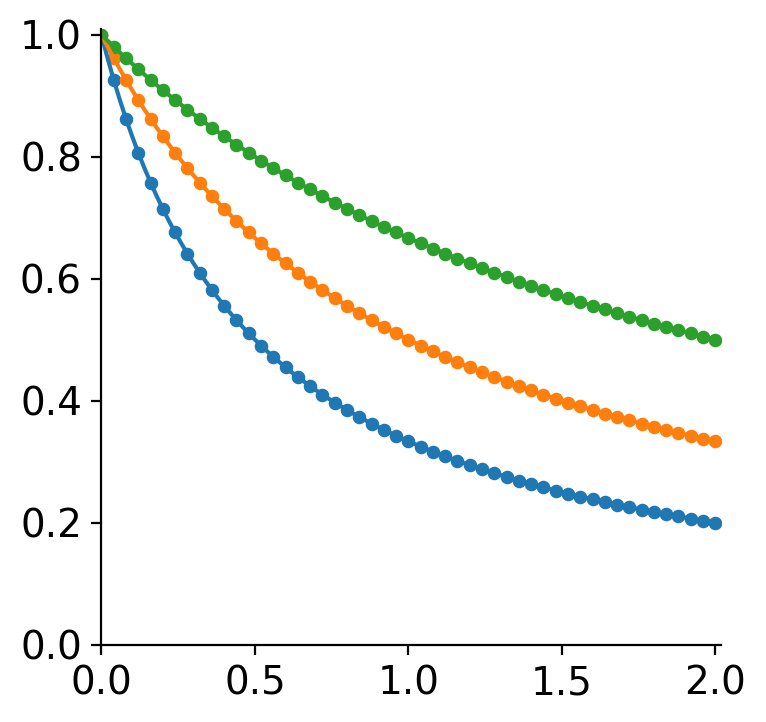

In [ ]:
# Figure 5D, left

fig, ax = plt.subplots(figsize=(4, 4))

x = tn([r.alpha for r in results_param_dict[(None, 0.5, 1)][0]])

dot_s = 15

ax.scatter(x, 1-results_param_dict[(None, 0.5, 1)][1], s=dot_s, color=dcolor[0])
ax.scatter(x, 1-results_param_dict[(None, 1, 1)][1], s=dot_s, color=dcolor[1])
ax.scatter(x, 1-results_param_dict[(None, 2, 1)][1], s=dot_s, color=dcolor[2])

# ax.plot(x, results_param_dict[(None, 0.5, 1)][2], lw=1, color=dcolor[0], linestyle=":")
# ax.plot(x, results_param_dict[(None, 1, 1)][2], lw=1, color=dcolor[1], linestyle=":")
# ax.plot(x, results_param_dict[(None, 2, 1)][2], lw=1, color=dcolor[2], linestyle=":")
# ax.plot(x, 1-inp_mod_lda, lw=2, color=dcolor[0])

x = np.linspace(0, 2, 201)

ax.plot(x, 1-x / (0.5+x), color=dcolor[0])
ax.plot(x, 1-x / (1+x), color=dcolor[1])
ax.plot(x, 1-x / (2+x), color=dcolor[2])

ax.set_xlim(0, 2.02)
ax.set_ylim(0, 1.01)

ax.spines[["top", "right"]].set_visible(False)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

save_figure("changing alpha", format="pdf")

In [21]:
alpha = 1
gamma = 1

result_list = list()

for beta in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(alpha, None, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:42<00:00,  3.18s/it]


In [22]:
alpha = 0.5
gamma = 1

result_list = list()

for beta in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(alpha, None, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:43<00:00,  3.22s/it]


In [23]:
alpha = 2
gamma = 1

result_list = list()

for beta in tqdm(np.linspace(0, 2, 51)):
#     gamma = (constant - alpha) / beta
    results = get_results(alpha, beta, gamma, g)
    result_list.append(results)
    
inp_mod_pred = list()
inp_mod_lda = list()
for rl in result_list:
    inp_mod_pred.append(rl.inp_mod)
    inp_mod_lda.append(rl.inp_mod_lda.mean().item())
inp_mod_pred = tn(inp_mod_pred)
inp_mod_lda = tn(inp_mod_lda)

results_param_dict[(alpha, None, gamma)] = (result_list, inp_mod_pred, inp_mod_lda)

100%|██████████| 51/51 [02:42<00:00,  3.19s/it]


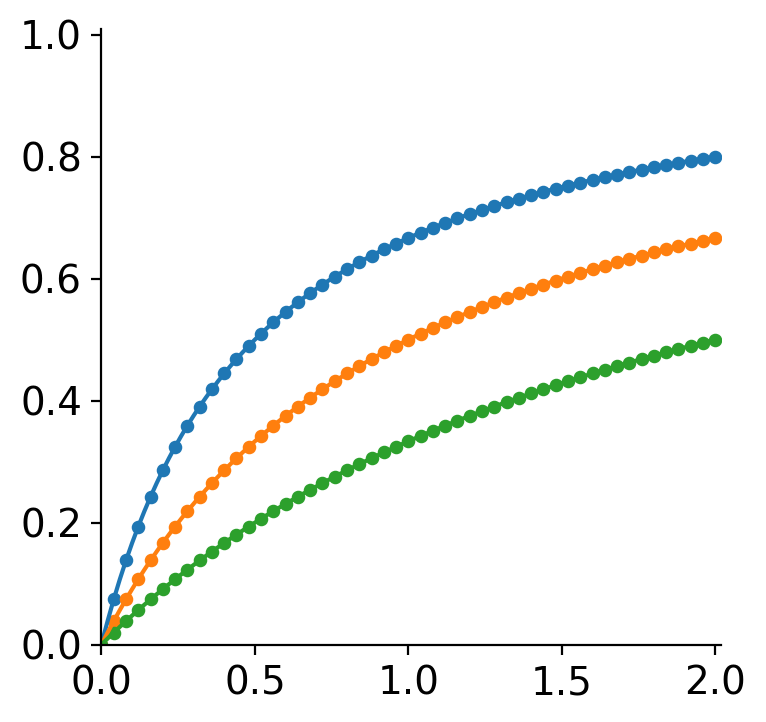

In [24]:
# Figure 5D, right

fig, ax = plt.subplots(figsize=(4, 4))

x = tn([r.beta for r in results_param_dict[(0.5, None, 1)][0]])

dot_s = 15

ax.scatter(x, 1-results_param_dict[(0.5, None, 1)][1], s=dot_s, color=dcolor[0])
ax.scatter(x, 1-results_param_dict[(1, None, 1)][1], s=dot_s, color=dcolor[1])
ax.scatter(x, 1-results_param_dict[(2, None, 1)][1], s=dot_s, color=dcolor[2])

# ax.plot(x, results_param_dict[(None, 0.5, 1)][2], lw=1, color=dcolor[0], linestyle=":")
# ax.plot(x, results_param_dict[(None, 1, 1)][2], lw=1, color=dcolor[1], linestyle=":")
# ax.plot(x, results_param_dict[(None, 2, 1)][2], lw=1, color=dcolor[2], linestyle=":")
# ax.plot(x, 1-inp_mod_lda, lw=2, color=dcolor[0])

x = np.linspace(0, 2, 201)

ax.plot(x, 1-0.5 / (0.5+x), color=dcolor[0])
ax.plot(x, 1-1 / (1+x), color=dcolor[1])
ax.plot(x, 1-2 / (2+x), color=dcolor[2])

ax.set_xlim(0, 2.02)
ax.set_ylim(0, 1.01)

ax.spines[["top", "right"]].set_visible(False)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

save_figure("changing beta", format="pdf")

In [29]:
def get_svs(alpha, beta, gamma, g):
    results = table()
    results.alpha = alpha
    results.gamma = gamma
    results.beta = beta
    results.inp_mod = alpha / (alpha + beta * gamma)
    results.sel_mod = beta * gamma / (alpha + beta * gamma)
    C = make_c(g, alpha, beta, gamma)
    rnn._C.data.copy_(C)
    rnn.resample(whiten=True)

    all_result = list()
    k = 10

    for j in range(k):
        result_dict = dict()
        with torch.no_grad():
            rnn.resample(whiten=True)
            sv = [None, None]
            I = [[None, None], [None, None]]
            choice = [None, None]
            gain = [None, None]
            rnn_U = rnn._U.reshape(-1, rnn.hyper.max_rank)
            rnn_V = rnn._V.reshape(-1, rnn.hyper.max_rank)
            rnn_I = rnn._I.reshape(-1, rnn.hyper.input_dim)
            spike_input, y, mask, cnds, ctx, cnd_ctx = get_spike_input(256, fixed_t=10)
            h = rnn(spike_input.to(device), noise_inp=0)
    #         print(h.shape)
            for c in [0, 1]:
                h1 = h[ctx == c, 10:20, :][:10].clone()
                x = h1.view(-1, h1.shape[-1]).detach().clone()
                with torch.enable_grad():
                    x.requires_grad_()
                    slow_point_optim = torch.optim.Adam([x], lr=1e-2)
                    ctx_vector = [[0.0, 0, 1, 0], [0.0, 0, 0, 1]][c]
                    for k in range(75):
                        slow_point_optim.zero_grad()
                        v = rnn.velocity(x, torch.tensor(ctx_vector).to(device).view(1, 4).repeat(x.shape[0], 1))
                        q = v.pow(2).sum(-1) * 0.5
                        loss = q.mean()
                        (loss).backward()
                        slow_point_optim.step()
    #                     tbar.set_postfix({"loss": np_str(loss.item()),
    #                                       })
                K = x[q < 1, :].shape[0]
                x1 = x[q < 1, :]
                gain1 = (1 - torch.tanh(x1).pow(2))
                rnn_GainedU = torch.einsum("bn,nr->bnr", gain1, rnn_U)
                rnn_GainedV = rnn_V.unsqueeze(0).repeat(gain1.shape[0], 1, 1)
                S = power_method_batch_lowrank(rnn_GainedU, rnn_GainedV)[0]
                i = (S-1).pow(2).min(dim=0).indices.item()
    #             print(S[i])

                x1 = x[q < 1, :][i]
                gain1 = (1 - torch.tanh(x1).pow(2))
                rnn_GainedU = torch.einsum("i,ir->ir", gain1, rnn_U)
                S, V = power_method_batch_lowrank(rnn_V, rnn_GainedU)
                sv[c] = V
                I[0][c] = gain1 * rnn_I[:, 0]
                I[1][c] = gain1 * rnn_I[:, 1]

                S, V = power_method_batch_lowrank(rnn_GainedU, rnn_V)
                choice[c] = V
                gain[c] = gain1
            if (sv[0] * I[0][0]).sum() < 0:
                sv[0] = -sv[0]
            if (choice[0] * sv[0]).sum() < 0:
                choice[0] = -choice[0]
            if (choice[1] * choice[0]).sum() < 0:
                choice[1] = -choice[1]
            if (sv[1] * choice[1]).sum() < 0:
                sv[1] = -sv[1]
            for r in range(2):
                sv[r] = sv[r] / (sv[r] * choice[r]).sum()
            sv_gt = [None, None]
            sv_gt[0] = rnn_V[:, 0] * beta + rnn_V[:, 1] * 0 + rnn_V[:, 2]
            sv_gt[1] = rnn_V[:, 0] * 0 + rnn_V[:, 1] * beta + rnn_V[:, 2]
            result_dict["sv"] = sv
            result_dict["sv_gt"] = sv_gt
    #         print(cosine_similarity(sv_gt[0], sv[0]), cosine_similarity(sv_gt[1], sv[1]))
        all_result.append(result_dict)
    results["results"] = all_result
    return results

In [30]:
K = 100
cs_matrix = torch.zeros(K, 10, 2)
for k in trange(K):
    alpha, beta, gamma = torch.rand(3) * 3
    rss = get_svs(alpha, beta, gamma, g)["results"]
    for i in range(10):
        r = rss[i]
        sv = r["sv"]
        sv_gt = r["sv_gt"]
        for j in range(2):
            cs_matrix[k, i, j] = cosine_similarity(sv_gt[j], sv[j])

100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


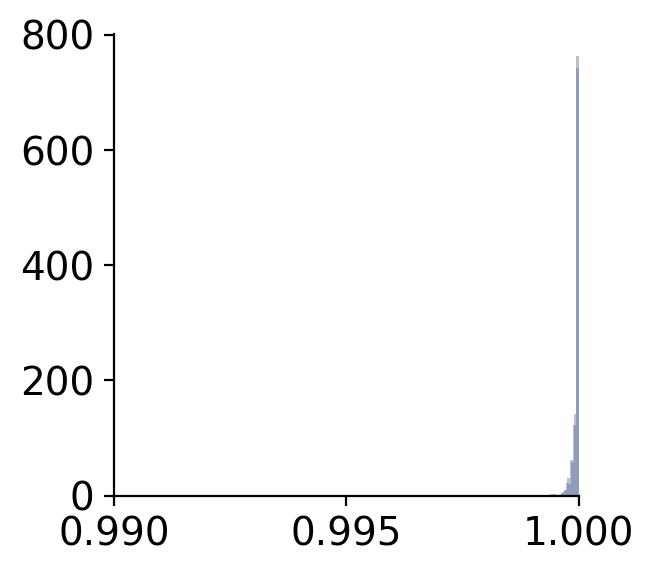

In [31]:
# Figure 6B

fig, ax = plt.subplots(figsize=(3,3))

ax.hist(cs_matrix[:, :, 0].flatten(), alpha=0.4, color=mod_color[0])
ax.hist(cs_matrix[:, :, 1].flatten(), alpha=0.4, color=mod_color[1])

ax.spines[["right", "top"]].set_visible(False)
ax.set_xlim(0.99, 1)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

save_figure("cos angle between estimated and theory sv", format="pdf")